<a href="https://colab.research.google.com/github/Aravind-98/Summer_Internship_2020/blob/master/file_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


In [2]:
!pip install pmdarima
!pip install pyramid-arima
!pip install pingouin
!pip install statsmodels

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 17.9MB/s 
     |████████████████████████████████| 8.7MB 25.9MB/s 
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 604kB 2.8MB/s 
     |████████████████████████████████| 225kB 2.8MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.6-cp36-none-any.whl size=217880 sha256=b68b4253ca74ef0d547a6b14e82cb6ebd51d5ce28e1073e241a3caed3366368c
  Stored in directory: /root/.cache/pip/wheels/0f/12/3e/c50f18f38eaf437b927b567ac6615215fdf75fe58890d32276
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=30b34b79474c6b9e7553286d50f1c9d8b0a8e1740527ec1c94207145978a0896
  Stored in directory: /root/.cache/pip/whee

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pingouin as pg
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, SimpleRNN, GRU, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
from pmdarima.arima import ndiffs
import pmdarima as pm
import scipy.stats as stats

def load_data(filename):
    df=pd.read_csv(filename)
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    df=df[df.columns[1:]]
    return df

def rolling_pc(df,sliding_window_size):
    new_data=[]
    columns=list(df.columns)
    for i in range(int(len(df)/sliding_window_size)):
        end=-(sliding_window_size)*i
        start=-(sliding_window_size)*(i+1)
        if i==0:
             extract=df.iloc[start:].copy()
        else:     
            extract=df.iloc[start:end].copy()
        #print(f"start: {start} end:{end} ")
        pcorr_vec=[]
        #print("~"*5+str(i)+"~"*5)
        for j in range(len(df.columns)-1):
            covar=list(set(columns[:-1]).difference({columns[j]}))
           # print("   "+columns[j]+" "+columns[-1])
            p_cor=pg.partial_corr(data=extract, x=columns[j], y=columns[-1], covar=covar, method='pearson').round(3)
            pcorr_vec.append(float(p_cor["r"]))
        new_data.append(pcorr_vec)
    new_data.reverse()    
    PCor_dataset=pd.DataFrame(np.array(new_data),columns=columns[:-1])
    return PCor_dataset

def get_residuals(df):
    forecast=[]
    residuals=[]
    for i in range(len(df.columns)):
        data=df[df.columns[i]]
        kpss_diffs = ndiffs(data, alpha=0.01, test='kpss', max_d=2)
        adf_diffs = ndiffs(data, alpha=0.01, test='adf', max_d=2)
        n_diffs = max(adf_diffs, kpss_diffs)

        #print(f"Estimated differencing term: {n_diffs}")
        model = pm.auto_arima(data, d=n_diffs, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_p=6, max_order=None, trace=False)
        #print(f"{df.columns[i]}   :::::   ARIMA model order:{model.order}")
        pred = list(model.predict_in_sample())
        resid=list(data-pred)
        residuals.append(resid) 
        fcast=model.predict(1)
        forecast.append(fcast) 
        #print(f"forecast shape:{np.array(forecast).shape}")
    
    Residuals=np.array(residuals).T
   
    forecast=np.array(forecast).T
    return Residuals,forecast    

def Arimizer(pre_ARIMA_data):
    D=[]
    #for i in range(len(pre_ARIMA_data.index)-window_size):
    #could probably store just arrays
    d=pd.DataFrame(np.array(pre_ARIMA_data.copy()),columns=pre_ARIMA_data.columns)
    r,forecast=get_residuals(d)
    #D.append(r)
    #print(f"   ~~ Iteration:{i+1} ~~")
    

    #,forecast=get_residuals(t,False)

    #test=np.concatenate((X_test,forecast)) #the last row is the forecast

    residual_data=np.concatenate((r,forecast),axis=0)
    #print(f"residual shape: {residual_data.shape}")
    return residual_data

def create_dataset(df,trn_prd,rebal_days,rolling_window_size):
    '''
    Returns the X, y, forecast dataframes for a given training period and rebalancing period.
    '''
    iter=int((2440-rebal_days-trn_prd)/rebal_days)
    X_pred=[]
    X_iter=[]
    y_iter=[]
    forecast=[]
    for t in range(iter):
        #####################################
        print(f"iteration {t+1}/{iter}")

        st_train=rebal_days*t
        end_train=rebal_days*t+trn_prd
        st_test=end_train
        end_test=st_test+rebal_days

        train_data=df.iloc[st_train:end_train]
        if t==0:
            print(f"shape of train data:{np.array(train_data).shape}")
        pre_ARIMA_data=rolling_pc(train_data,30)
        residual_data=Arimizer(pre_ARIMA_data)
        #print(f"shape of residual_data: {residual_data.shape}")
        X=[]
        y=[]
        for i in range(int((len(residual_data)-rolling_window_size)/rolling_window_size)):
            X.append(residual_data[rolling_window_size*i:rolling_window_size*(i+1),:])
           #print(residual_data[rolling_window_size*i:rolling_window_size*(i+1),:].shape)
            y.append(residual_data[rolling_window_size*(i+1),:])
        X_pred.append(residual_data[-rolling_window_size-1:-1,:])
        forecast.append(residual_data[-1,:])
        #u=np.concatenate(tuple(X))
        u=np.array(X)
        #v=np.concatenate(tuple(y))
        v=np.array(y)
        X_iter.append(u)
        y_iter.append(v)
    X=np.concatenate(tuple(X_iter))
    X_p=np.array(X_pred)
    y=np.concatenate(tuple(y_iter))
    ARIMA_forecast=np.array(forecast)
    # X contains train+dev+test
    # y contain only train+dev
    #X=pd.DataFrame(X,columns=df.columns[:-1])
    #y=pd.DataFrame(y,columns=df.columns[:-1])
    #ARIMA_forecast=pd.DataFrame(ARIMA_forecast,columns=df.columns[:-1])
    return X, y, X_p,ARIMA_forecast

In [6]:
df=load_data("Price_All.csv")
X_whole, y_whole, X_Pred, arima_forecast=create_dataset(df,450,30,5)    

print(f"Shapes: X:{X_whole.shape} y:{y_whole.shape} X_pred:{X_Pred.shape} forecast{arima_forecast.shape}")
X_store=pd.DataFrame(np.reshape(X_whole,(-1,46)),columns=df.columns[:-1])
y_store=pd.DataFrame(y_whole,columns=df.columns[:-1])
X_predict=pd.DataFrame(np.reshape(X_Pred,(-1,46)),columns=df.columns[:-1])
linear_forecast=pd.DataFrame(arima_forecast,columns=df.columns[:-1])

from google.colab import files
X_store.to_csv('X_store_450_30.csv')
y_store.to_csv('y_store_450_30.csv')
X_predict.to_csv('X_predict_450_30.csv')
linear_forecast.to_csv('linear_forecast_450_30.csv') 

files.download('X_store_450_30.csv')
files.download('y_store_450_30.csv')
files.download('X_predict_450_30.csv')
files.download('linear_forecast_450_30.csv') 

iteration 1/65
shape of train data:(450, 47)
iteration 2/65
iteration 3/65
iteration 4/65
iteration 5/65
iteration 6/65
iteration 7/65
iteration 8/65
iteration 9/65
iteration 10/65
iteration 11/65
iteration 12/65
iteration 13/65
iteration 14/65
iteration 15/65
iteration 16/65
iteration 17/65
iteration 18/65
iteration 19/65
iteration 20/65
iteration 21/65
iteration 22/65
iteration 23/65
iteration 24/65
iteration 25/65
iteration 26/65
iteration 27/65
iteration 28/65
iteration 29/65
iteration 30/65
iteration 31/65
iteration 32/65
iteration 33/65
iteration 34/65
iteration 35/65
iteration 36/65
iteration 37/65
iteration 38/65
iteration 39/65
iteration 40/65
iteration 41/65
iteration 42/65
iteration 43/65
iteration 44/65
iteration 45/65
iteration 46/65
iteration 47/65
iteration 48/65
iteration 49/65
iteration 50/65
iteration 51/65
iteration 52/65
iteration 53/65
iteration 54/65
iteration 55/65
iteration 56/65
iteration 57/65
iteration 58/65
iteration 59/65
iteration 60/65
iteration 61/65
ite

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train on 100 samples, validate on 30 samples
Epoch 1/150
100/100 [==============================] - 1s 10ms/step - loss: 33.1827 - mse: 0.3890 - val_loss: 29.3417 - val_mse: 0.4306
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 26.6004 - mse: 0.3801 - val_loss: 24.0934 - val_mse: 0.4286
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 22.3522 - mse: 0.3773 - val_loss: 20.8026 - val_mse: 0.4276
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 19.6833 - mse: 0.3771 - val_loss: 18.7089 - val_mse: 0.4271
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 17.9502 - mse: 0.3779 - val_loss: 17.3037 - val_mse: 0.4268
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 16.7470 - mse: 0.3788 - val_loss: 16.2805 - val_mse: 0.4270
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 15.8323 - mse: 0.3797 - val_loss: 15.4622 - val_mse: 0.4269
Epoch 8/1

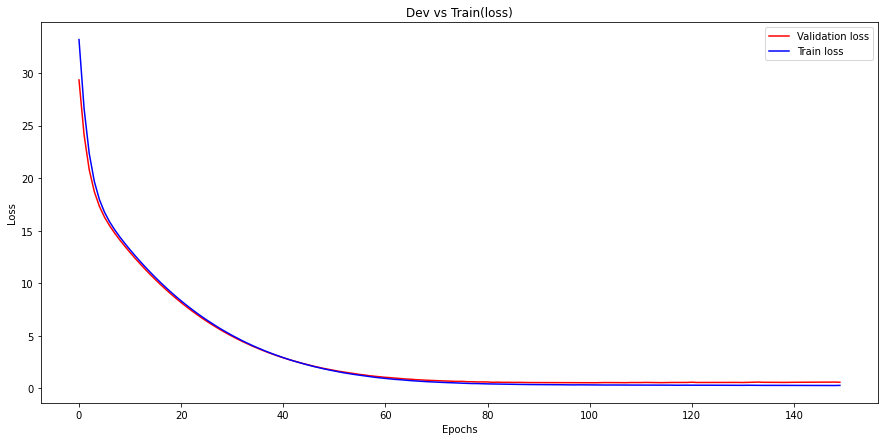

In [54]:
from keras.layers import Dense, LSTM, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.regularizers import l1_l2
from keras import backend as K

class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})


X_train, y_train, X_dev, y_dev=X_whole[:100,:,:], y_whole[:100,:], X_whole[100:,:,:], y_whole[100:,:]
n_steps=X_train.shape[1]
n_features=X_train.shape[2]

model=Sequential()
model.add(LSTM(100,activation='tanh',return_sequences=True,recurrent_dropout=0.4,
                    input_shape=(n_steps, n_features),kernel_regularizer=l1_l2(0,0.2), bias_regularizer=l1_l2(0,0.2)))

model.add(TimeDistributed(Dropout(0.2)))
model.add(LSTM(n_features,recurrent_activation="sigmoid"))
model.add(Activation(double_tanh))
model.compile(optimizer='adam', loss="mse", metrics=["mse"])

history=model.fit(X_train, y_train, epochs=150, batch_size=5,verbose=1,validation_data=(X_dev,y_dev))
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss))
plt.figure(figsize=(15,7))
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.plot(epochs, loss, 'b',label='Train loss')
plt.title('Dev vs Train(loss)',fontsize='large')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [11]:
arima_forecast.shape

(65, 46)

In [46]:
pre_final_predictions=np.add(model.predict(X_Pred),arima_forecast)
#pre_final=pd.DataFrame(final_predictions,columns=df.columns[:-1])
ones=np.ones(pre_final_predictions.shape)
filter=np.maximum(pre_final_predictions,-ones)
final_predictions=np.minimum(filter,ones)
final=pd.DataFrame(final_predictions,columns=df.columns[:-1])


In [ ]:
final.to_csv("final_450_30.csv")
files.download('final_450_30.csv')

In [36]:
def rebal_pcorr(df,rebal_days,trn_prd):
    iter=int((2440-rebal_days-trn_prd)/rebal_days)
    reb_data=[]
    for t in range(iter):
        #####################################
        print(f"iteration {t+1}/{iter}")

        start=rebal_days*t+trn_prd
        end=start+rebal_days

        data=df.iloc[start:end].copy()
        if t==0:
            print(f"shape of data:{np.array(data).shape}")
        pc_data=rolling_pc(data,rebal_days)
        reb_data.append(list(pc_data.iloc[0].copy()))
    data=pd.DataFrame(np.array(reb_data),columns=df.columns[:-1])   
    return data

In [16]:
actual_pcorr=rebal_pcorr(df,30,450)

iteration 1/65
shape of data:(30, 47)
iteration 2/65
iteration 3/65
iteration 4/65
iteration 5/65
iteration 6/65
iteration 7/65
iteration 8/65
iteration 9/65
iteration 10/65
iteration 11/65
iteration 12/65
iteration 13/65
iteration 14/65
iteration 15/65
iteration 16/65
iteration 17/65
iteration 18/65
iteration 19/65
iteration 20/65
iteration 21/65
iteration 22/65
iteration 23/65
iteration 24/65
iteration 25/65
iteration 26/65
iteration 27/65
iteration 28/65
iteration 29/65
iteration 30/65
iteration 31/65
iteration 32/65
iteration 33/65
iteration 34/65
iteration 35/65
iteration 36/65
iteration 37/65
iteration 38/65
iteration 39/65
iteration 40/65
iteration 41/65
iteration 42/65
iteration 43/65
iteration 44/65
iteration 45/65
iteration 46/65
iteration 47/65
iteration 48/65
iteration 49/65
iteration 50/65
iteration 51/65
iteration 52/65
iteration 53/65
iteration 54/65
iteration 55/65
iteration 56/65
iteration 57/65
iteration 58/65
iteration 59/65
iteration 60/65
iteration 61/65
iteration 

In [43]:
col_ind=list(np.argsort(list(actual_pcorr.iloc[-1])))
ans_1=list(final.columns[col_ind])[::-1]
ans_1

['Price_43',
 'Price_20',
 'Price_12',
 'Price_29',
 'Price_26',
 'Price_45',
 'Price_31',
 'Price_48',
 'Price_49',
 'Price_21',
 'Price_47',
 'Price_23',
 'Price_24',
 'Price_38',
 'Price_3',
 'Price_5',
 'Price_30',
 'Price_36',
 'Price_46',
 'Price_28',
 'Price_32',
 'Price_42',
 'Price_39',
 'Price_2',
 'Price_41',
 'Price_1',
 'Price_37',
 'Price_33',
 'Price_22',
 'Price_44',
 'Price_14',
 'Price_4',
 'Price_34',
 'Price_9',
 'Price_16',
 'Price_8',
 'Price_50',
 'Price_11',
 'Price_27',
 'Price_18',
 'Price_19',
 'Price_7',
 'Price_15',
 'Price_40',
 'Price_35',
 'Price_17']

In [44]:
col_ind=list(np.argsort(list(final.iloc[-1])))
ans=list(final.columns[col_ind])[::-1]
ans

['Price_5',
 'Price_30',
 'Price_4',
 'Price_35',
 'Price_36',
 'Price_1',
 'Price_22',
 'Price_21',
 'Price_40',
 'Price_43',
 'Price_31',
 'Price_34',
 'Price_24',
 'Price_45',
 'Price_48',
 'Price_42',
 'Price_12',
 'Price_2',
 'Price_9',
 'Price_28',
 'Price_8',
 'Price_23',
 'Price_19',
 'Price_14',
 'Price_3',
 'Price_39',
 'Price_11',
 'Price_38',
 'Price_32',
 'Price_44',
 'Price_20',
 'Price_26',
 'Price_17',
 'Price_49',
 'Price_41',
 'Price_46',
 'Price_18',
 'Price_15',
 'Price_50',
 'Price_47',
 'Price_16',
 'Price_7',
 'Price_37',
 'Price_33',
 'Price_29',
 'Price_27']

In [59]:
a_fc=pd.DataFrame(arima_forecast,columns=df.columns[:-1])

In [79]:
def plot_forecast(i):
    plt.figure(figsize=(20,7))
    plt.plot(np.array(final.iloc[i]),"--o",label="pred")
    plt.plot(np.array(actual_pcorr.iloc[i]),"--o",label="actual")
    plt.plot(np.array(a_fc.iloc[i]),"-*",label="arima_forecast")
    plt.legend()

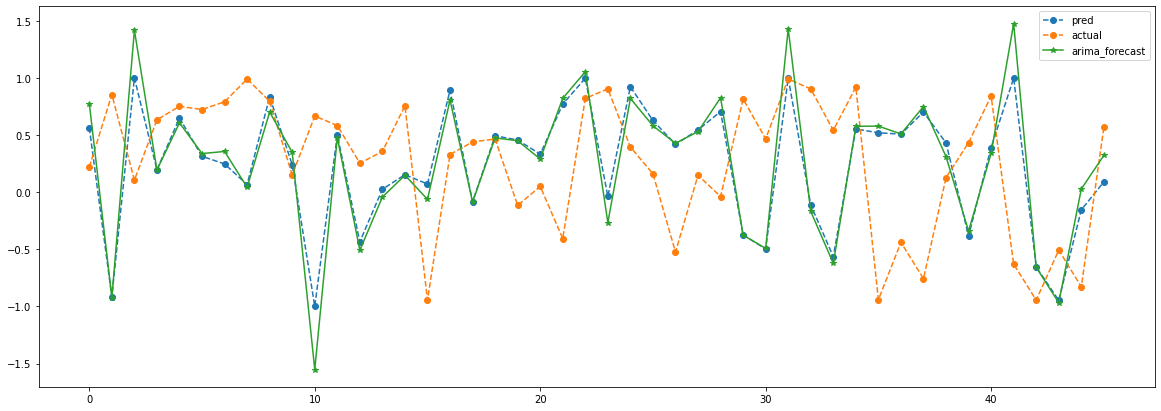

In [80]:
plot_forecast(3)

In [52]:
np.array((ans_1[:10],ans[:10]))

array([['Price_43', 'Price_20', 'Price_12', 'Price_29', 'Price_26',
        'Price_45', 'Price_31', 'Price_48', 'Price_49', 'Price_21'],
       ['Price_5', 'Price_30', 'Price_4', 'Price_35', 'Price_36',
        'Price_1', 'Price_22', 'Price_21', 'Price_40', 'Price_43']],
      dtype='<U8')